### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

## 1)
Read in hw5_data_1.npy. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [1]:
#IMPORTS
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from scipy.stats import laplace

import corner

Text(0, 0.5, 'Flux (arb.)')

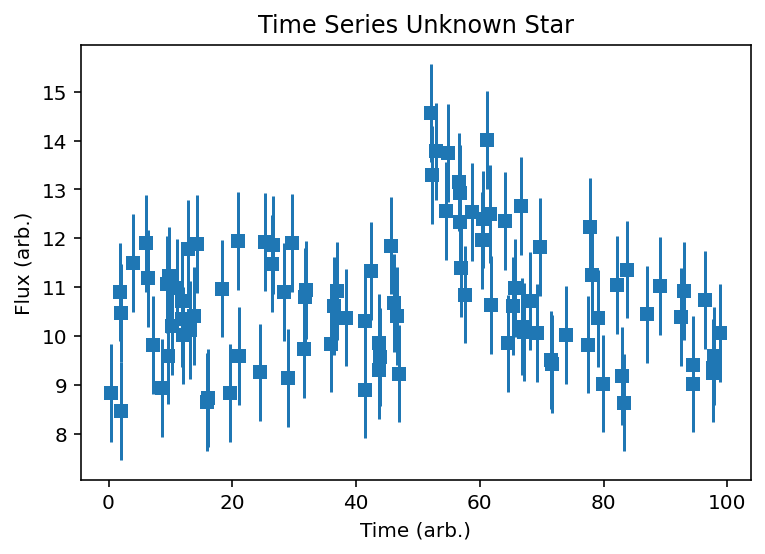

In [2]:
filename = '../../homeworks/hw_data/hw5_data_1.npy' 

data_star = np.load(filename)
time = data_star[:,0]
flux  = data_star[:,1]
uncert  = data_star[:,2]

plt.errorbar(time, flux, yerr = uncert, fmt ='s')
plt.title('Time Series Unknown Star')
plt.xlabel('Time (arb.)')
plt.ylabel('Flux (arb.)')

## 2) 
One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 



$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - m_i)^2}{2\sigma_i^2}.$$

In [3]:
def burst_model(t, params):
    
    b = params[0]
    A = params[1]
    t_0 = params[2]
    alpha = params[3]
    
    y = np.where(t < t_0 , b, b + A * np.exp(-alpha*(t-t_0)))
    return y 
#    if t < t_0:
 #       y = b
  #      return y 
  #  else: 
   #     y = b + A * np.exp(-alpha*(t-t_0))
    #    return y 
    
    
def lkl_brust(flux, model, uncert):
    lnL_temp = np.array([])
    N_points = len(flux)
    for index in range(N_points): 
        lnL_1 = (flux[index]-model[index])**2/(2*uncert[index]**2)
        lnL_temp = np.append(lnL_temp, lnL_1)
    lnL = np.sum(lnL_temp)
    return -lnL #negative ? 



## 3)
Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.



In [4]:
def log_prior_params(params):
    b = params[0]
    A = params[1]
    t_0 = params[2]
    alpha = params[3]
    
    b_model = uniform.pdf(b, 0, 50)
    A_model = uniform.pdf(A, 0, 50)
    t_0_model = uniform.pdf(t_0, 0, 100)
    ln_alpha_model = uniform.pdf(np.log(alpha), -5 ,5)
    
    prior = b_model*A_model*t_0_model*ln_alpha_model
    return np.log(prior)

def logL(params):
    b = params[0]
    A = params[1]
    t_0 = params[2]
    alpha = params[3]
    model = burst_model(time, params)
    return sum(norm.logpdf(flux,model,uncert))
   # return np.log(lkl_brust(flux, model ,uncert))
    
    

Text(0, 0.5, 'Flux (arb.)')

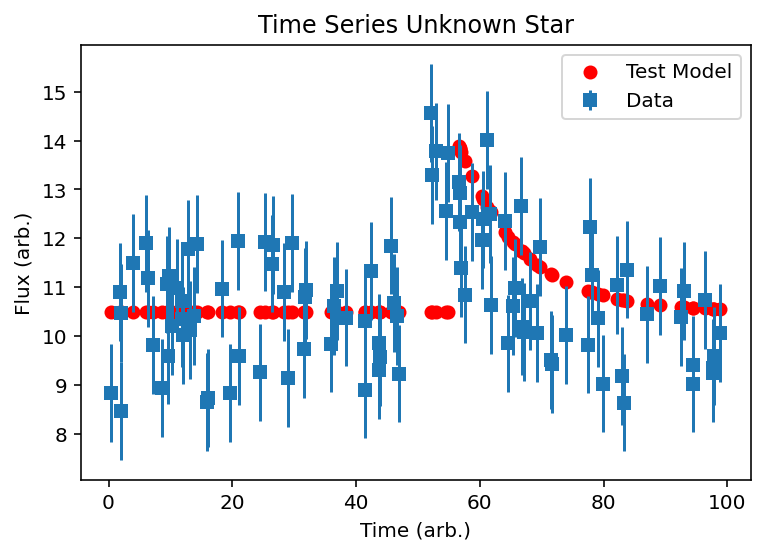

In [5]:
b=10.5
A=4
t_0=55
alpha=0.1
test_params = np.array([b, A, t_0, alpha])

model=burst_model(time, test_params)
plt.errorbar(time,flux, yerr= uncert, fmt ='s', label = 'Data')
plt.scatter(time,model, color = 'red', label = 'Test Model')
plt.legend(loc='upper right')
plt.title('Time Series Unknown Star')
plt.xlabel('Time (arb.)')
plt.ylabel('Flux (arb.)')

 Atempt with PTMCMCSampler

In [6]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [7]:
# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, log_prior_params, cov, 
                 outDir='./my_ptmcmc_chain_HW5', resume=False)


In [8]:
# sampler for N steps
N = int(1.5e5)
rand_params = np.array([10., 10., 50., 1.])
print(test_params)
sampler.sample(test_params, N)#, SCAMweight=30, AMweight=15, DEweight=50)

[10.5  4.  55.   0.1]


/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


Finished 0.67 percent in 0.803378 s Acceptance rate = 0.936

/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Finished 6.67 percent in 8.243703 s Acceptance rate = 0.423289Adding DE jump with weight 20
Finished 99.33 percent in 124.262738 s Acceptance rate = 0.397792
Run Complete


In [9]:
chain = np.loadtxt('./my_ptmcmc_chain_HW5/chain_1.txt')

mcmc_b = chain[:,0]
mcmc_A = chain[:,1]
mcmc_t = chain[:,2]
mcmc_alpha = chain[:,3]

xgrid = np.linspace(0, len(mcmc_b), len(mcmc_b))
                    
chain.shape

(14900, 8)

In [10]:
chain[0,:4]
#chain[1,:4]


array([10.5,  4. , 55. ,  0.1])

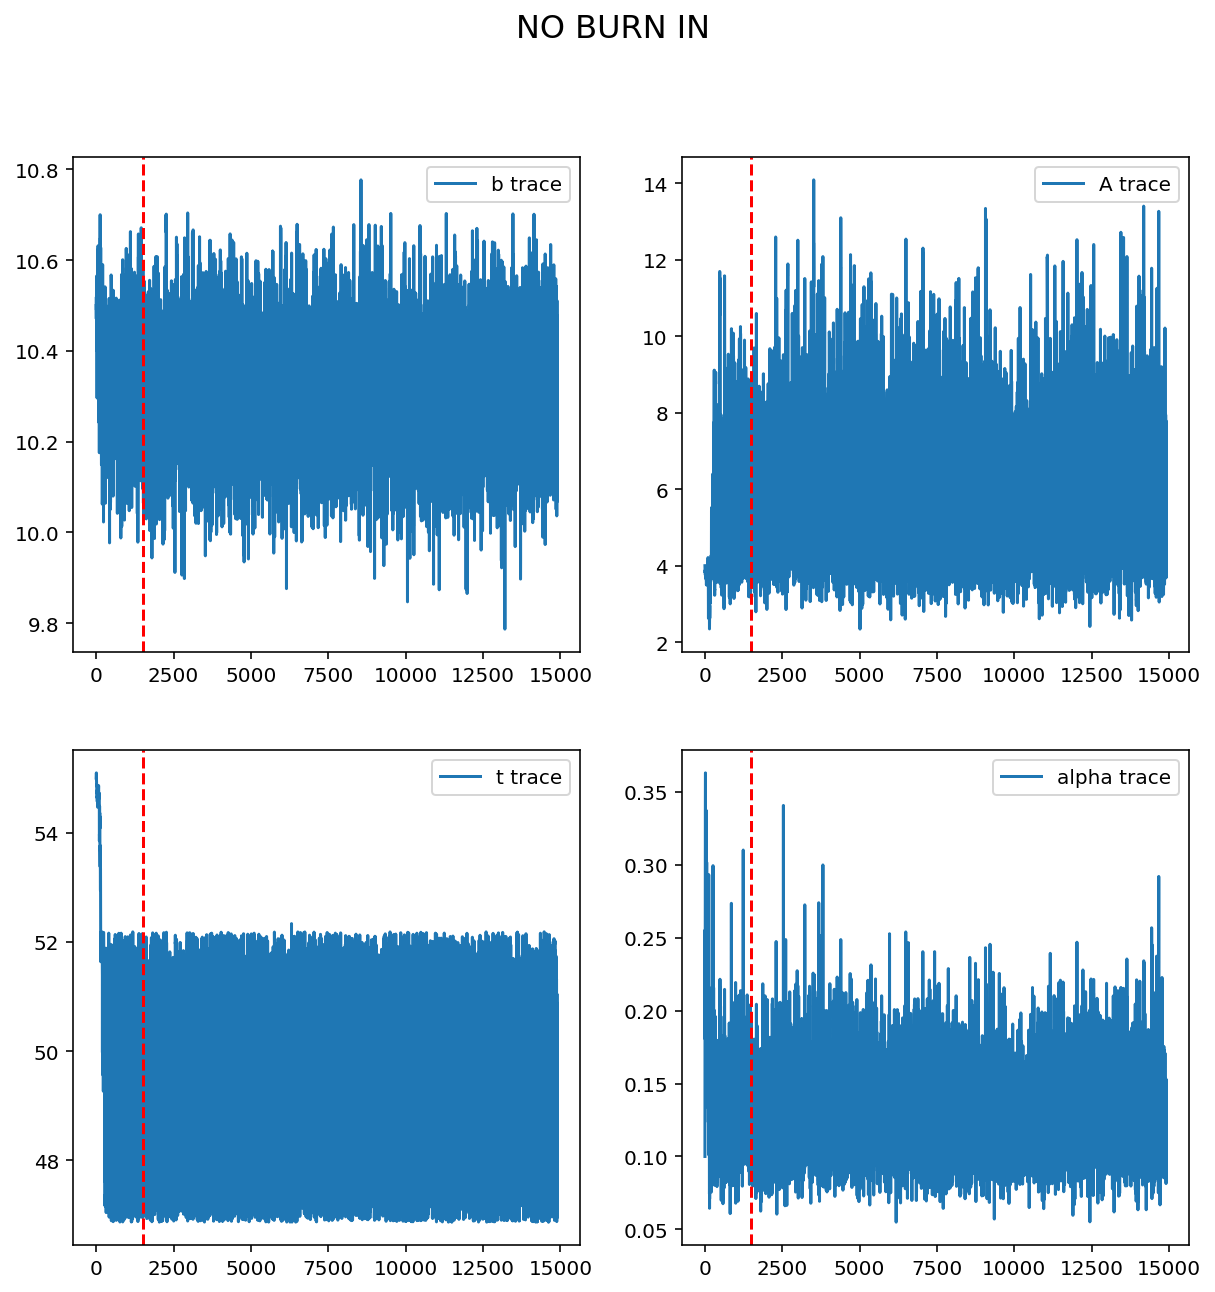

In [11]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('NO BURN IN', fontsize=16)
N_burn = 1500


b_trace_plot = fig.add_subplot(2,2,1)
b_trace_plot.plot(xgrid, mcmc_b, label = 'b trace',)
b_trace_plot.axvline(N_burn,ls='--',c='r')
b_trace_plot.legend(loc = 'upper right')

A_trace_plot = fig.add_subplot(2,2,2)
A_trace_plot.plot(xgrid, mcmc_A, label = 'A trace')
A_trace_plot.axvline(N_burn,ls='--',c='r')
A_trace_plot.legend(loc = 'upper right')

t_trace_plot = fig.add_subplot(2,2,3)
t_trace_plot.plot(xgrid, mcmc_t, label = 't trace')
t_trace_plot.axvline(N_burn,ls='--',c='r')
t_trace_plot.legend(loc = 'upper right')

alpha_trace_plot = fig.add_subplot(2,2,4)
alpha_trace_plot.plot(xgrid, mcmc_alpha, label = 'alpha trace')
alpha_trace_plot.axvline(N_burn,ls='--',c='r')
alpha_trace_plot.legend(loc = 'upper right')

## 4)
Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).



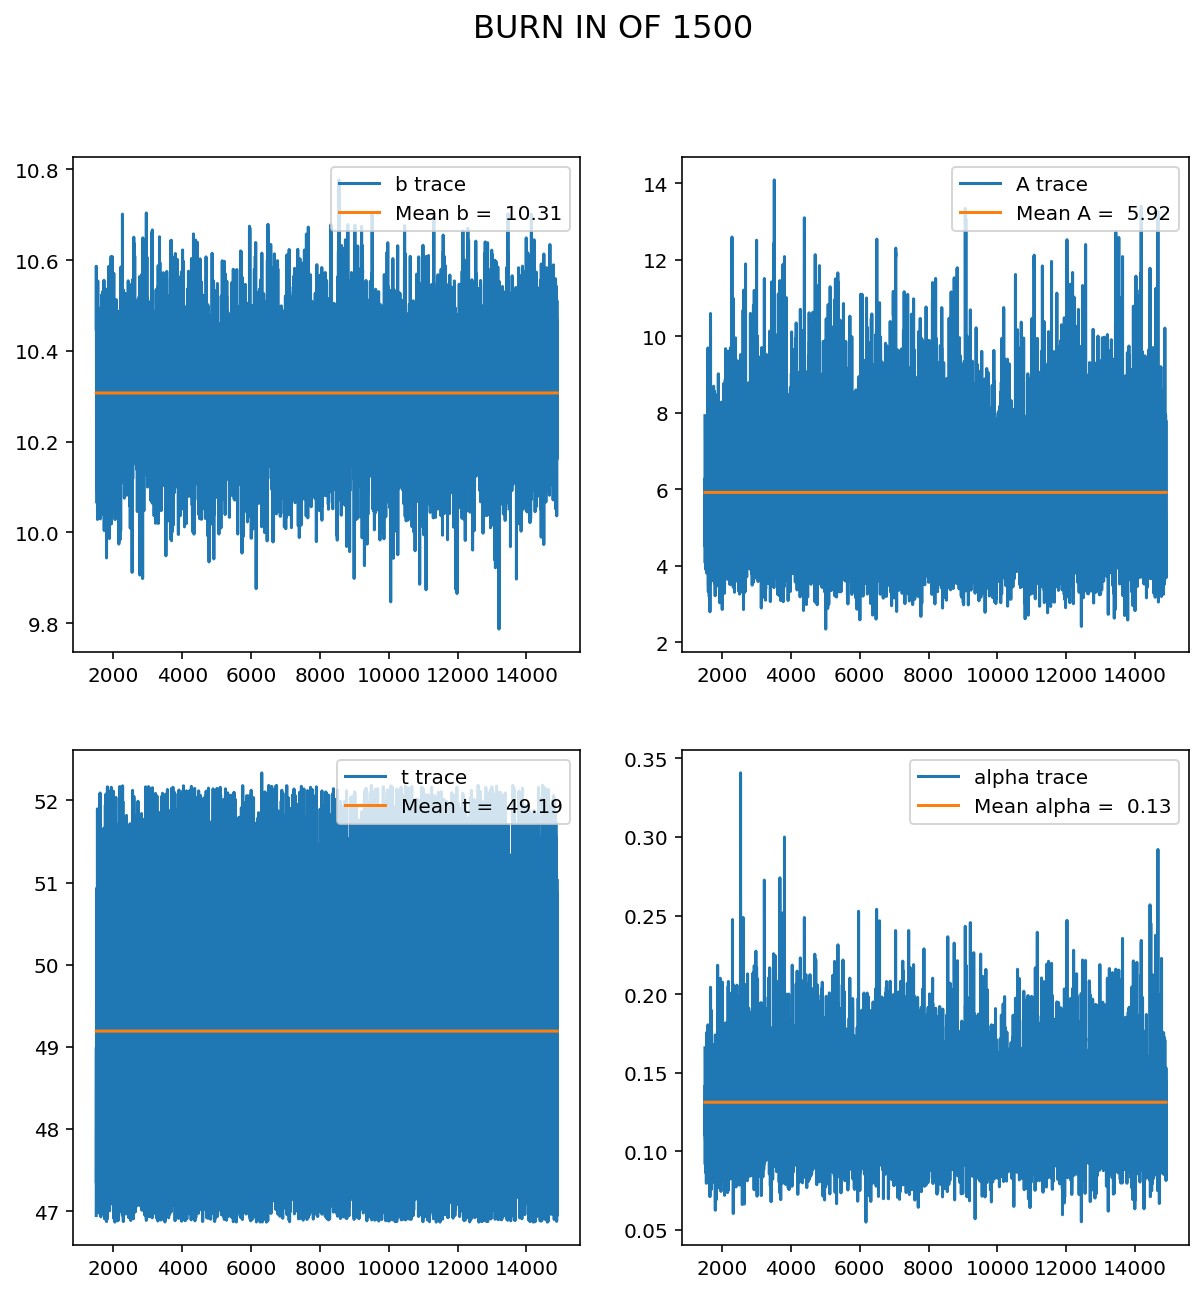

In [12]:
N_burn = 1500
fig = plt.figure(figsize=(10, 10))
fig.suptitle('BURN IN OF ' + str(N_burn) , fontsize=16)


ones = np.ones(len(xgrid[N_burn:]))


b_trace_plot = fig.add_subplot(2,2,1)
b_trace_plot.plot(xgrid[N_burn:], mcmc_b[N_burn:], label = 'b trace')
b_trace_plot.plot(xgrid[N_burn:], np.mean(mcmc_b[N_burn:])*ones, label = 'Mean b =  {:.2f}'.format(np.mean(mcmc_b[N_burn:])))
b_trace_plot.legend(loc = 'upper right')

A_trace_plot = fig.add_subplot(2,2,2)
A_trace_plot.plot(xgrid[N_burn:], mcmc_A[N_burn:], label = 'A trace')
A_trace_plot.plot(xgrid[N_burn:], np.mean(mcmc_A[N_burn:])*ones, label = 'Mean A =  {:.2f}'.format(np.mean(mcmc_A[N_burn:])))
A_trace_plot.legend(loc = 'upper right')

t_trace_plot = fig.add_subplot(2,2,3)
t_trace_plot.plot(xgrid[N_burn:], mcmc_t[N_burn:], label = 't trace')
t_trace_plot.plot(xgrid[N_burn:], np.mean(mcmc_t[N_burn:])*ones, label = 'Mean t =  {:.2f}'.format(np.mean(mcmc_t[N_burn:])))
t_trace_plot.legend(loc = 'upper right')

alpha_trace_plot = fig.add_subplot(2,2,4)
alpha_trace_plot.plot(xgrid[N_burn:], mcmc_alpha[N_burn:], label = 'alpha trace')
alpha_trace_plot.plot(xgrid[N_burn:], np.mean(mcmc_alpha[N_burn:])*ones, label = 'Mean alpha =  {:.2f}'.format(np.mean(mcmc_alpha[N_burn:])))
alpha_trace_plot.legend(loc = 'upper right')

(4.41937676409521, 10.30945909452613, 0.002119340174285934)
(11.143936890994992, 5.879516521335288, 0.046324592096083264)
(28.394442990682077, 49.25668771054729, 0.069199563820288)
(12.046946343458643, 0.13183446635969595, 0.0008456092285963273)


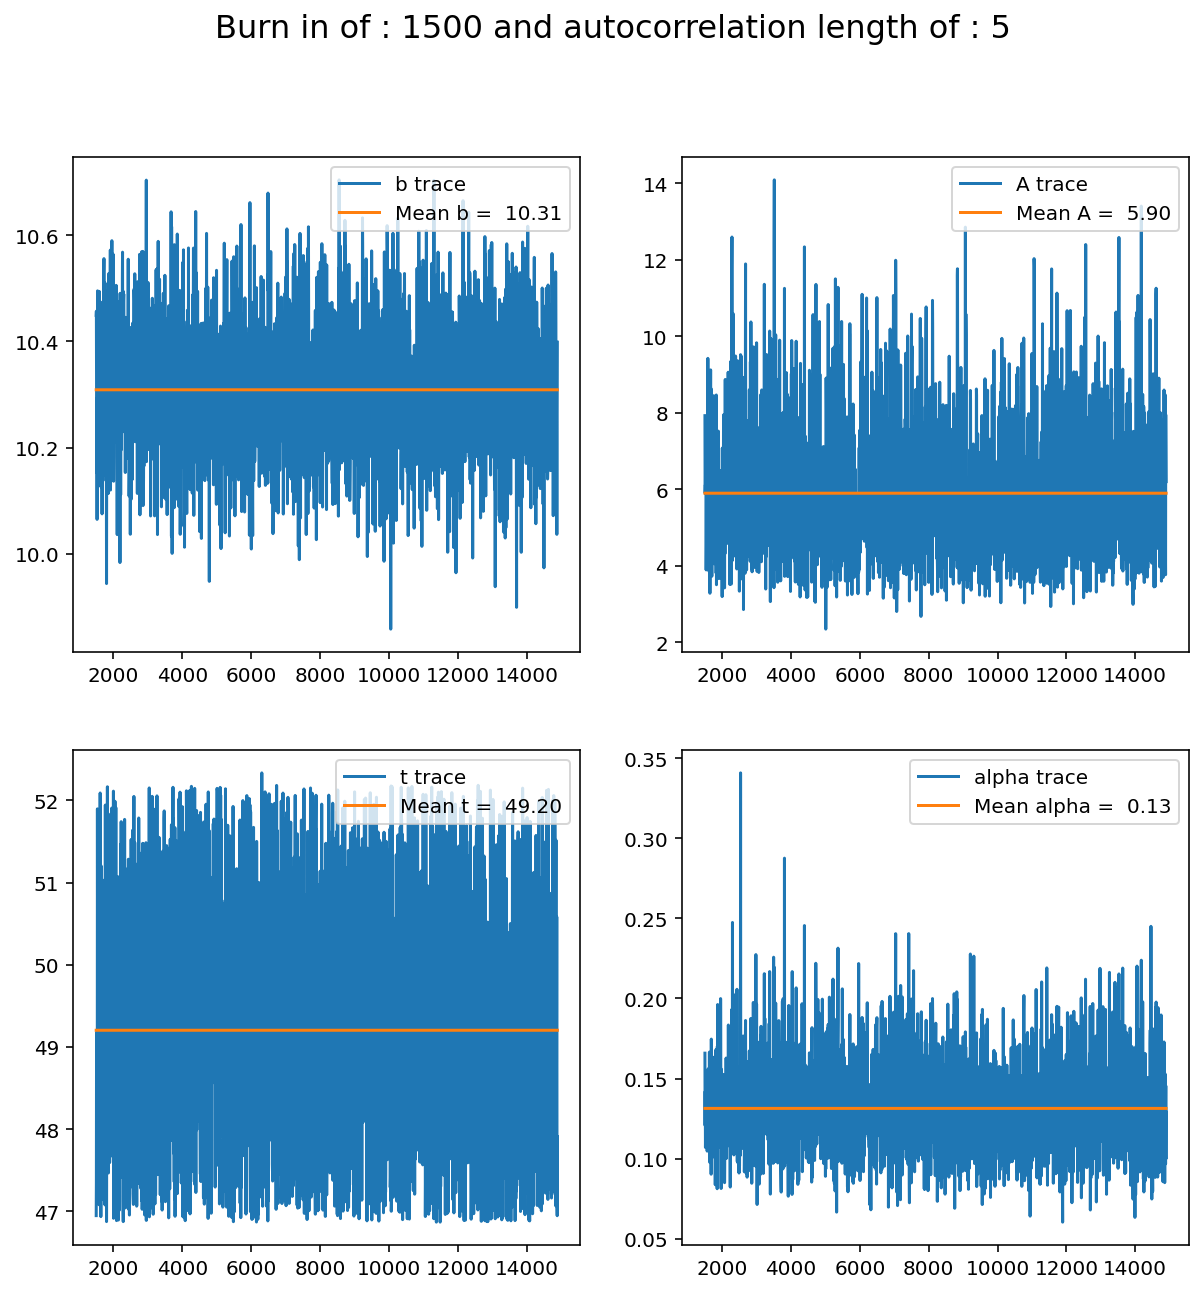

In [13]:
import acor
thin_b = (acor.acor(chain[:,0]))
thin_A = (acor.acor(chain[:,1]))
thin_t = (acor.acor(chain[:,2]))
thin_alpha = (acor.acor(chain[:,3]))
print(thin_b)
print(thin_A)
print(thin_t)
print(thin_alpha)

thin = int(acor.acor(chain[:,1])[1])


fig = plt.figure(figsize=(10, 10))


fig.suptitle('Burn in of : ' + str(N_burn) + ' and autocorrelation length of : ' + str(thin) , fontsize=16)


ones = np.ones(len(xgrid[N_burn::thin]))


b_trace_plot = fig.add_subplot(2,2,1)
b_trace_plot.plot(xgrid[N_burn::thin], mcmc_b[N_burn::thin], label = 'b trace')
b_trace_plot.plot(xgrid[N_burn::thin], np.mean(mcmc_b[N_burn::thin])*ones, label = 'Mean b =  {:.2f}'.format(np.mean(mcmc_b[N_burn::thin])))
b_trace_plot.legend(loc = 'upper right')

A_trace_plot = fig.add_subplot(2,2,2)
A_trace_plot.plot(xgrid[N_burn::thin], mcmc_A[N_burn::thin], label = 'A trace')
A_trace_plot.plot(xgrid[N_burn::thin], np.mean(mcmc_A[N_burn::thin])*ones, label = 'Mean A =  {:.2f}'.format(np.mean(mcmc_A[N_burn::thin])))
A_trace_plot.legend(loc = 'upper right')

t_trace_plot = fig.add_subplot(2,2,3)
t_trace_plot.plot(xgrid[N_burn::thin], mcmc_t[N_burn::thin], label = 't trace')
t_trace_plot.plot(xgrid[N_burn::thin], np.mean(mcmc_t[N_burn::thin])*ones, label = 'Mean t =  {:.2f}'.format(np.mean(mcmc_t[N_burn::thin])))
t_trace_plot.legend(loc = 'upper right')

alpha_trace_plot = fig.add_subplot(2,2,4)
alpha_trace_plot.plot(xgrid[N_burn::thin], mcmc_alpha[N_burn::thin], label = 'alpha trace')
alpha_trace_plot.plot(xgrid[N_burn::thin], np.mean(mcmc_alpha[N_burn::thin])*ones, label = 'Mean alpha =  {:.2f}'.format(np.mean(mcmc_alpha[N_burn::thin])))
alpha_trace_plot.legend(loc = 'upper right')

[10.5  4.  55.   0.1]
[10.31  5.91 49.2   0.13]


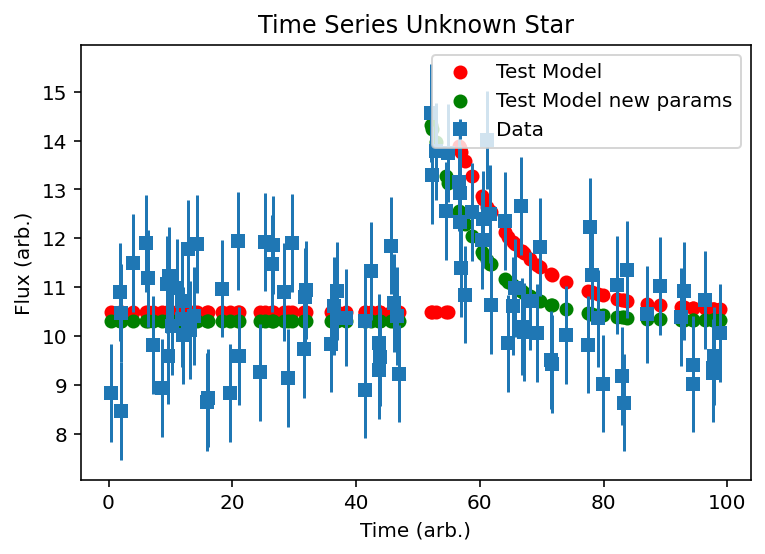

In [14]:
new_params = np.array([10.31, 5.91, 49.20, 0.13])

model2=burst_model(time, new_params)
plt.errorbar(time,flux, yerr= uncert, fmt ='s', label = 'Data')
plt.scatter(time,model, color = 'red', label = 'Test Model')
plt.scatter(time,model2, color = 'green', label = 'Test Model new params')

plt.legend(loc='upper right')
plt.title('Time Series Unknown Star')
plt.xlabel('Time (arb.)')
plt.ylabel('Flux (arb.)')
print(test_params)
print(new_params)

#### Something was wrong with my 'b' value. It was jumping to ~39 when the initial b value is 10.5 and should be closer to ~10, but I think I fixed it.... 

## 5)
Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.



In [15]:
print(len(chain[:,:4]))
print(len(chain[N_burn:,:4])) 
print(len(chain[N_burn:,:4])/thin)
print(len(chain[N_burn:,:4][::thin]))


chain[0,:4]


14900
13400
2680.0
2680


array([10.5,  4. , 55. ,  0.1])

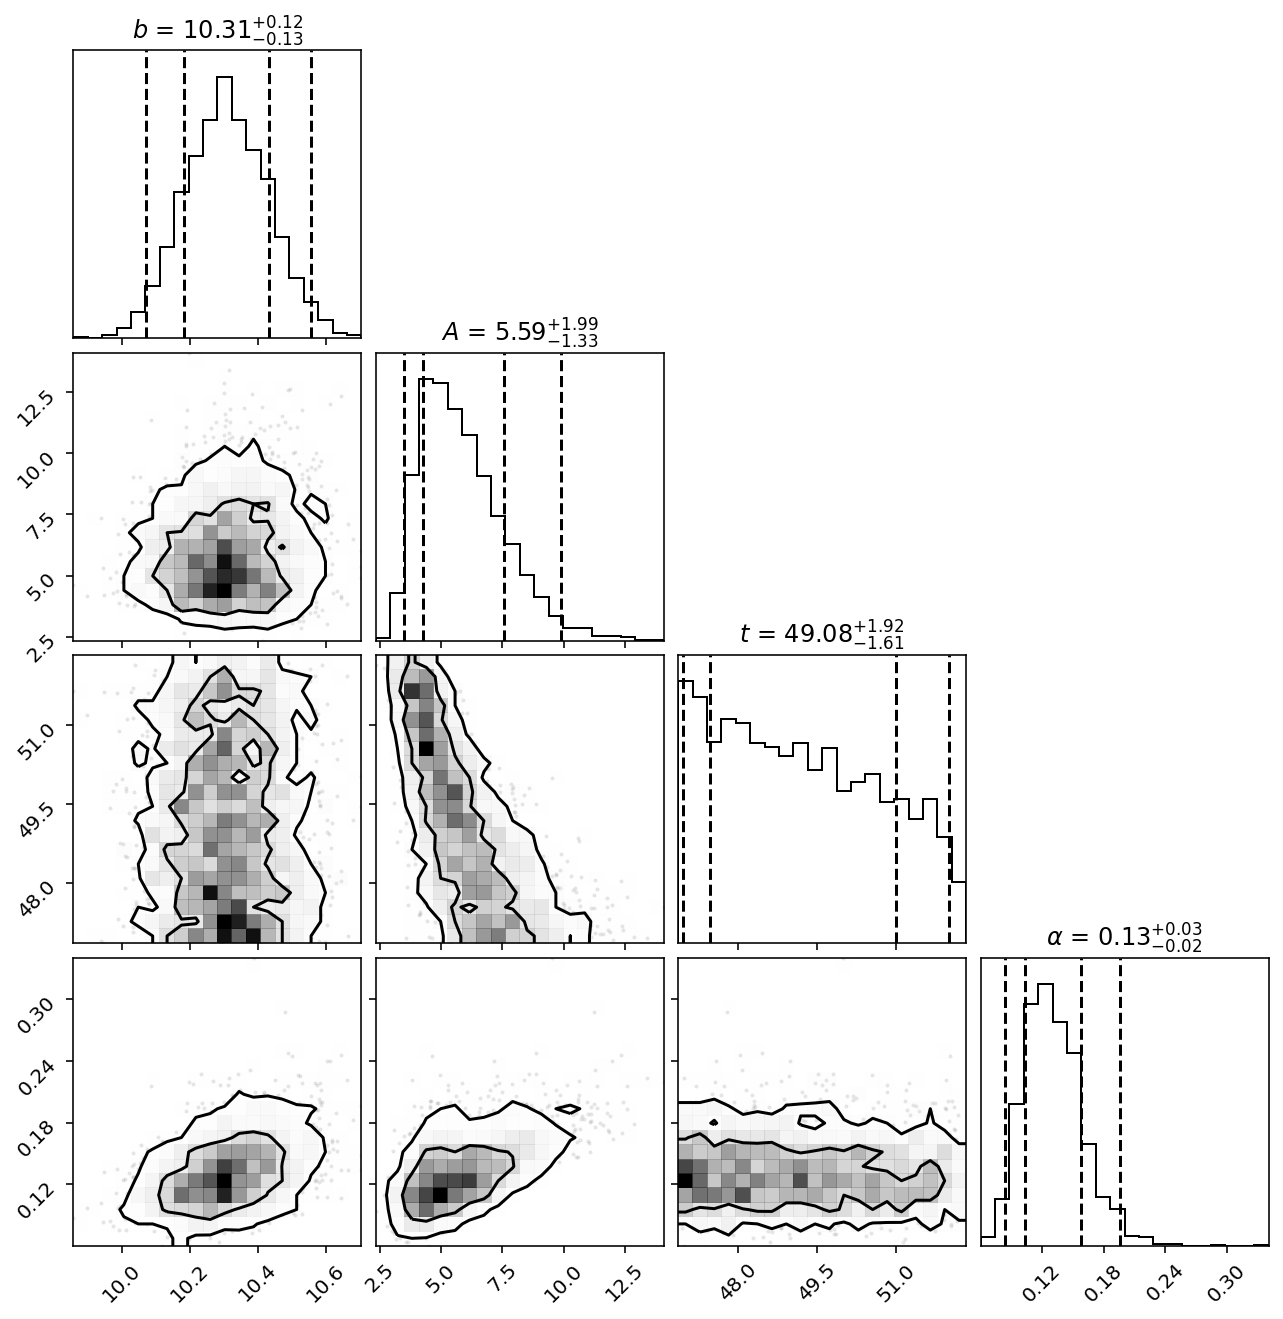

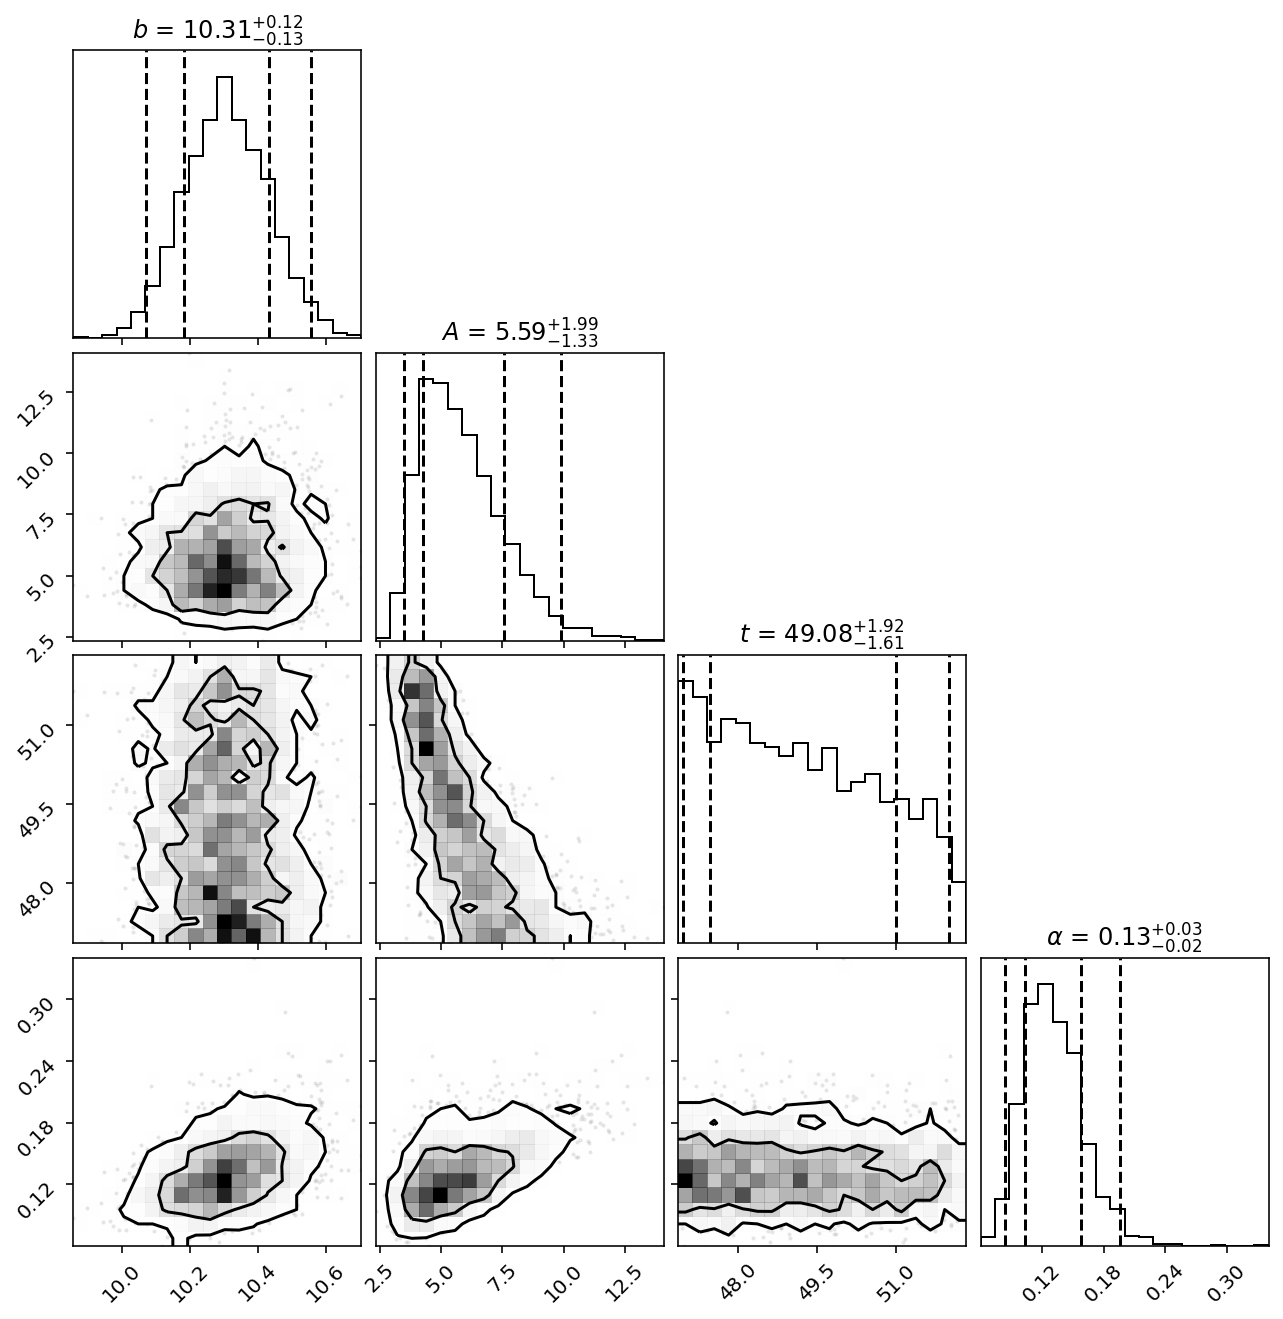

In [16]:
#Corner Plots
import corner 
#print(chain.shape)
chain_new = chain[N_burn:]

#corner.corner(chain[N_burn:,:4][::thin], bins=30, levels=(0.68, 0.95), quantiles=(0.16, 0.84),
#              labels=(r'$b$', r'$A$', r'$t$', r'$\alpha$'),show_titles = True)


corner.corner(chain[:,:4][N_burn::thin], titles=(r'$b$', r'$A$', r'$t$', r'$\alpha$'), show_titles=True,
              levels=[.68,.95], quantiles=(0.16, 0.84, .025, .975))



6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.



Text(0, 0.5, 'Flux (arb.)')

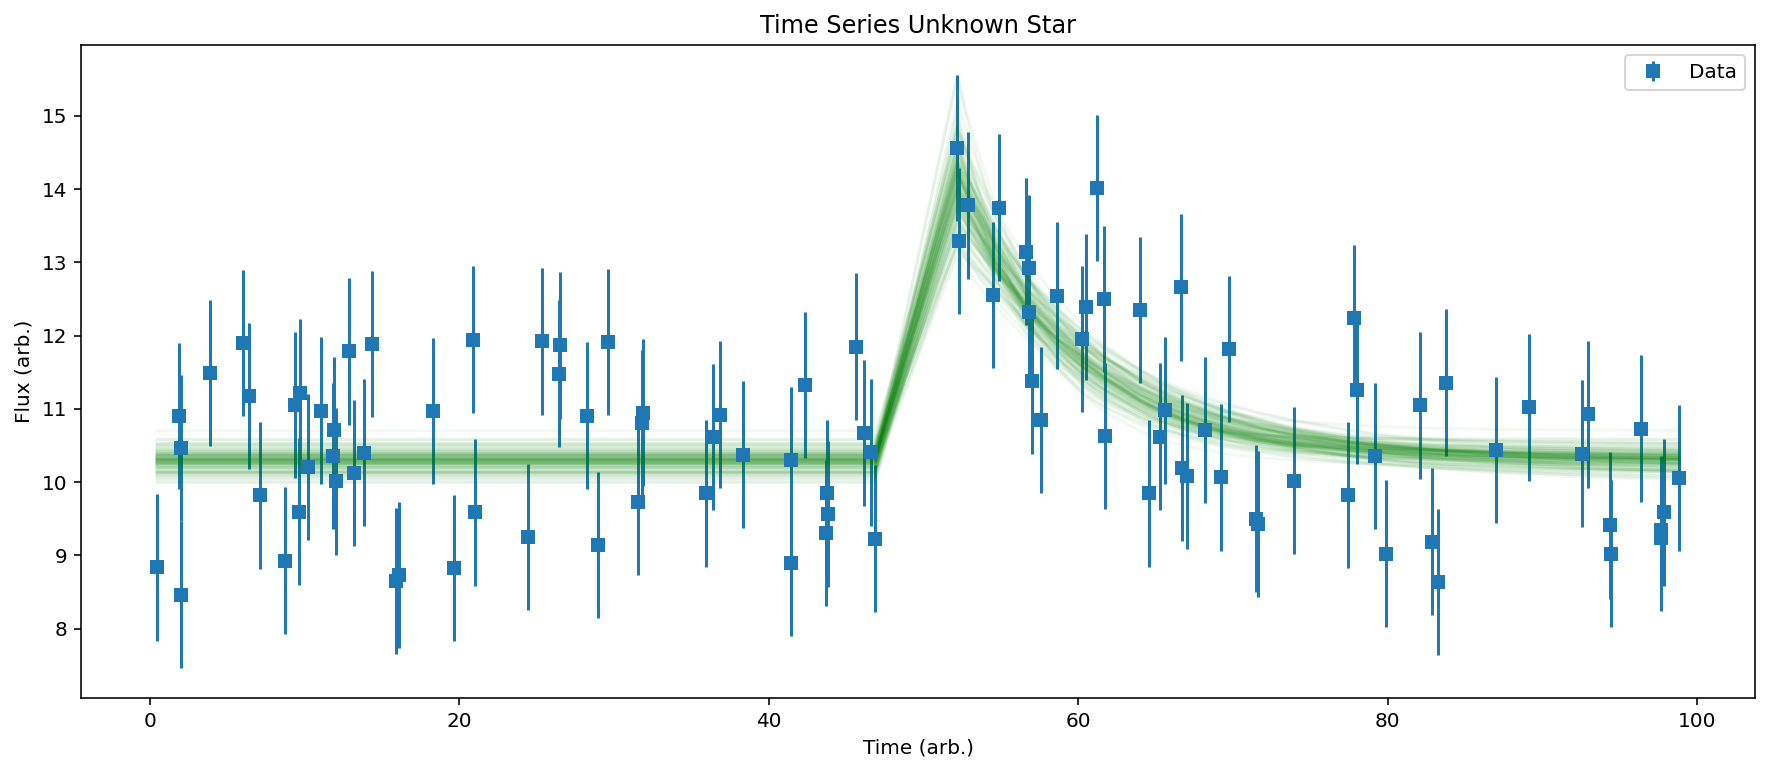

In [17]:
from numpy.random import choice
rand_samples = choice(chain[N_burn:,:4][::thin].shape[0], 100, replace=False)
rand_mcmc = chain[N_burn:,:4][::thin][rand_samples]

# overplot on data
plt.figure(figsize=(15,6))


for mcmc_param in rand_mcmc:
    plt.plot(time, burst_model(time, mcmc_param), alpha=0.05, c='g')

plt.errorbar(time,flux, yerr= uncert, fmt ='s', label = 'Data')
plt.legend(loc='upper right')
plt.title('Time Series Unknown Star')
plt.xlabel('Time (arb.)')
plt.ylabel('Flux (arb.)')


7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [18]:
def gauss_model_new(t, params):
    
    b = params[0]
    A = params[1]
    t_0 = params[2]
    sigma_W = params[3]
    
    y = np.where(t < t_0 , b, b + A * np.exp(-(t-t_0)**2/(2*sigma_W**2)))
    return y 

    
def lkl_brust_new(flux, model, uncert):
    lnL_temp2 = np.array([])
    N_points = len(flux)
    for index in range(N_points): 
        lnL_1 = (flux[index]-model[index])**2/(2*uncert[index]**2)
        lnL_temp2 = np.append(lnL_temp2, lnL_1)
    lnL = np.sum(lnL_temp)
    return -lnL #negative ? 

def log_prior_params_new(params):
    b = params[0]
    A = params[1]
    t_0 = params[2]
    sigma_W = params[3]
    
    b_model = uniform.pdf(b, 0, 50)
    A_model = uniform.pdf(A, 0, 50)
    t_0_model = uniform.pdf(t_0, 0, 100)
    #ln_alpha_model = uniform.pdf(np.log(alpha), -5 ,5)
    sigma_W_model = uniform.pdf(sigma_W, -2, 2)

    prior = b_model*A_model*t_0_model*sigma_W_model
    return np.log(prior)


def logL_gauss_new(params):
    b = params[0]
    A = params[1]
    t_0 = params[2]
    sigma_W = params[3]
    model = gauss_model_new(time, params)
    return sum(norm.logpdf(flux,model,uncert))
   # return np.log(lkl_brust(flux, model ,uncert))
    
    

import dynesty
from dynesty import plotting as dyplot

ndim=4
sampler = dynesty.NestedSampler(logL_new, log_prior_params_new, ndim)
sampler.run_nested()
gauss_results = sampler.results

In [19]:
import ultranest

param1 = ['b', 'A', 't_0', 'alpha']
param2 = ['b', 'A', 't_0', 'sigma_W']

def prior_burst2(params):
    # params = b, A, t_0, alpha
    params_copy = params.copy()
    
    #b 
    lo, hi = 0, 50
    params_copy[0] = params[0] * (hi - lo) + lo
    
    #A 
    lo, hi = 0, 50
    params_copy[1] = params[1] * (hi - lo) + lo
    
    # t_0
    lo, hi = 0, 100
    params_copy[2] = params[2] * (hi - lo) + lo
    
    #alpha
    lo, hi = -5, 5
    #ln_alpha = np.log(params[3])
    params_copy[3] = params[3] * (hi - lo) + lo
    params_copy[3] = np.exp(params[3])
    
    return params_copy


def prior_gauss(params):
    # params = b, A, t_0, sigma_W
    params_copy = params.copy()
    
    #b
    lo, hi = 0, 50
    params_copy[0] = params[0] * (hi - lo) + lo

    #A
    lo, hi = 0, 50
    params_copy[1] = params[1] * (hi - lo) + lo
    
    #t_0
    lo, hi = 0, 100
    params_copy[2] = params[2] * (hi - lo) + lo
    
    #sigma_W
    lo, hi = -2, 2
   # ln_sigma_W = np.log(params[3])
    params_copy[3] = params[3] * (hi - lo) + lo
    params_copy[3] = np.exp(params[3])

    
    return params_copy

In [20]:
sampler2 = ultranest.ReactiveNestedSampler(param1, logL, prior_burst2,
                                log_dir='ultranest_HW/burst/', resume='overwrite')
burst = sampler2.run(show_status=False)
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  
[ultranest] Likelihood function evaluations: 48963
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -175.2 +- 0.14
[ultranest] Effective samples strategy satisfied (ESS = 2138.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.31, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -175.160 +- 0.246
  single instance: logZ = -175.160 +- 0.162
  bootstrapped   : logZ = -175.151 +- 0.246
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   10.65 +- 0.11
    A                   27 +- 13
    t_0                 50.70 +- 0.60
    alpha               1.24 +- 0.28


In [21]:
sampler3 = ultranest.ReactiveNestedSampler(param2, logL_gauss_new, prior_gauss,
                                log_dir='ultranest_HW/gauss/', resume='overwrite')
# run the sampler
gauss = sampler3.run(show_status=False)
sampler3.print_results()


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  
[ultranest] Likelihood function evaluations: 61121
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -169.3 +- 0.1427
[ultranest] Effective samples strategy satisfied (ESS = 2675.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.29, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -169.328 +- 0.277
  single instance: logZ = -169.328 +- 0.188
  bootstrapped   : logZ = -169.346 +- 0.277
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   10.56 +- 0.10
    A                   4.1 +- 1.7
    t_0                 51.78 +- 0.50
    sigma_W             2.55 +- 0.16


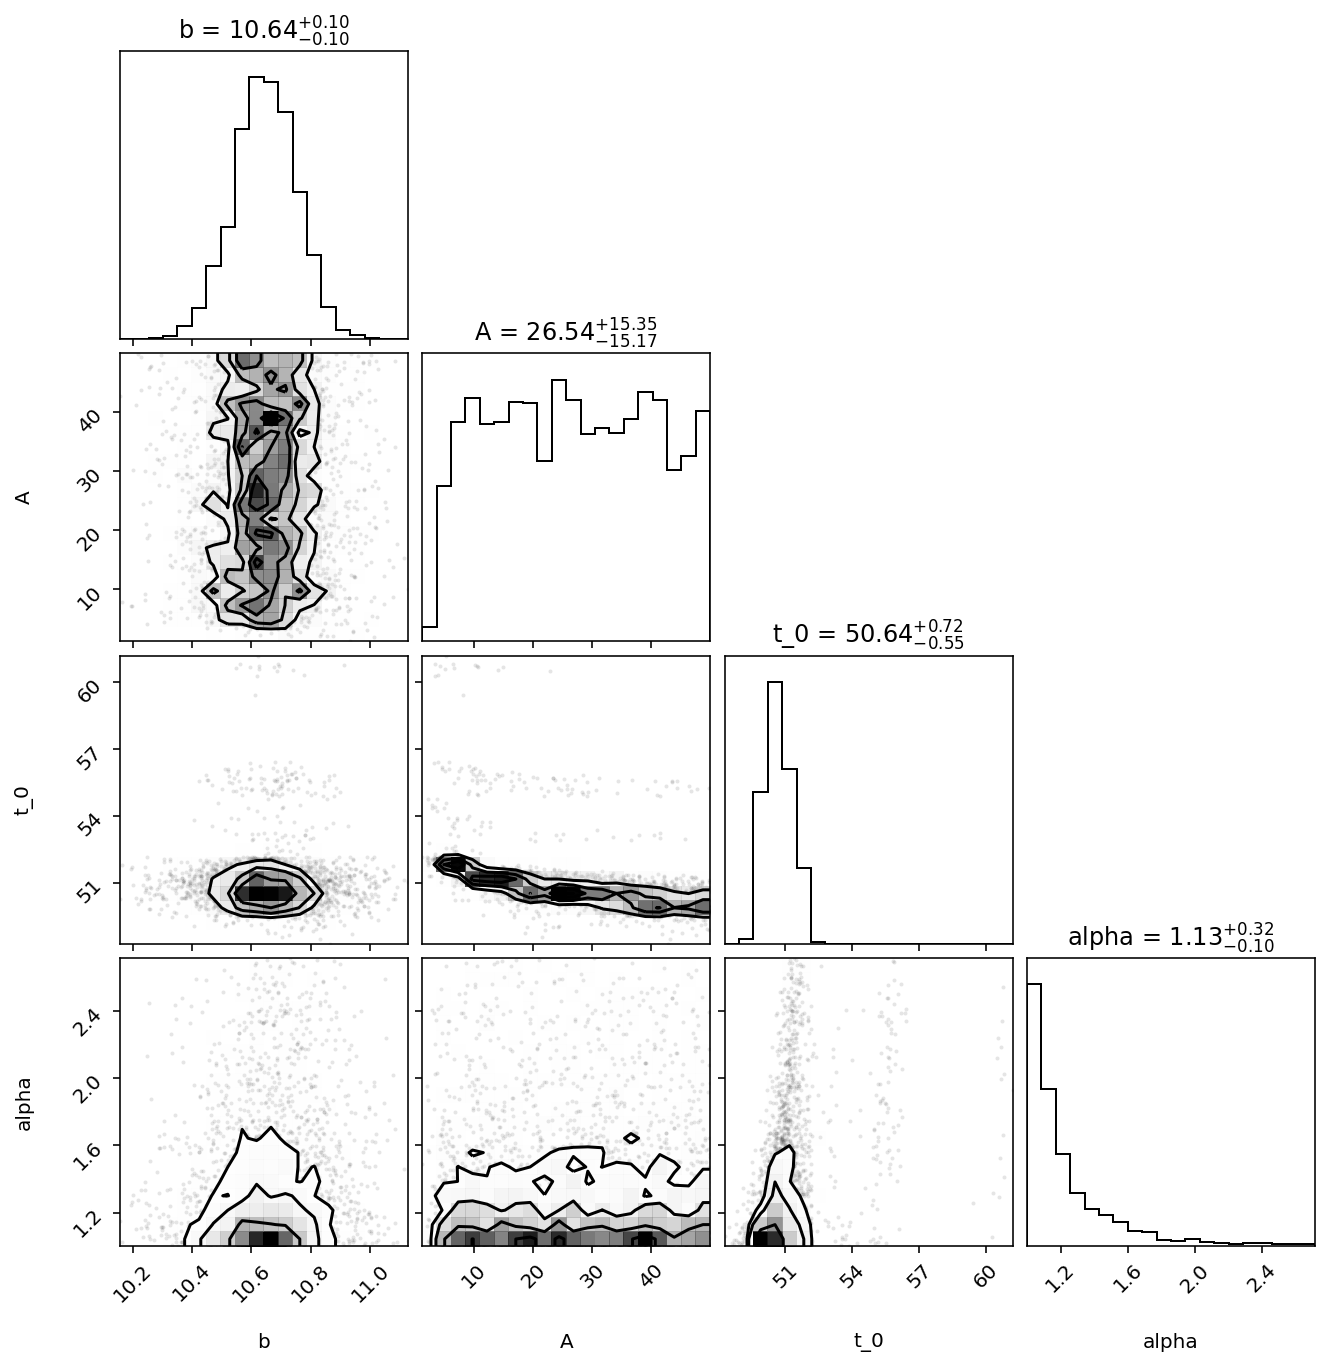

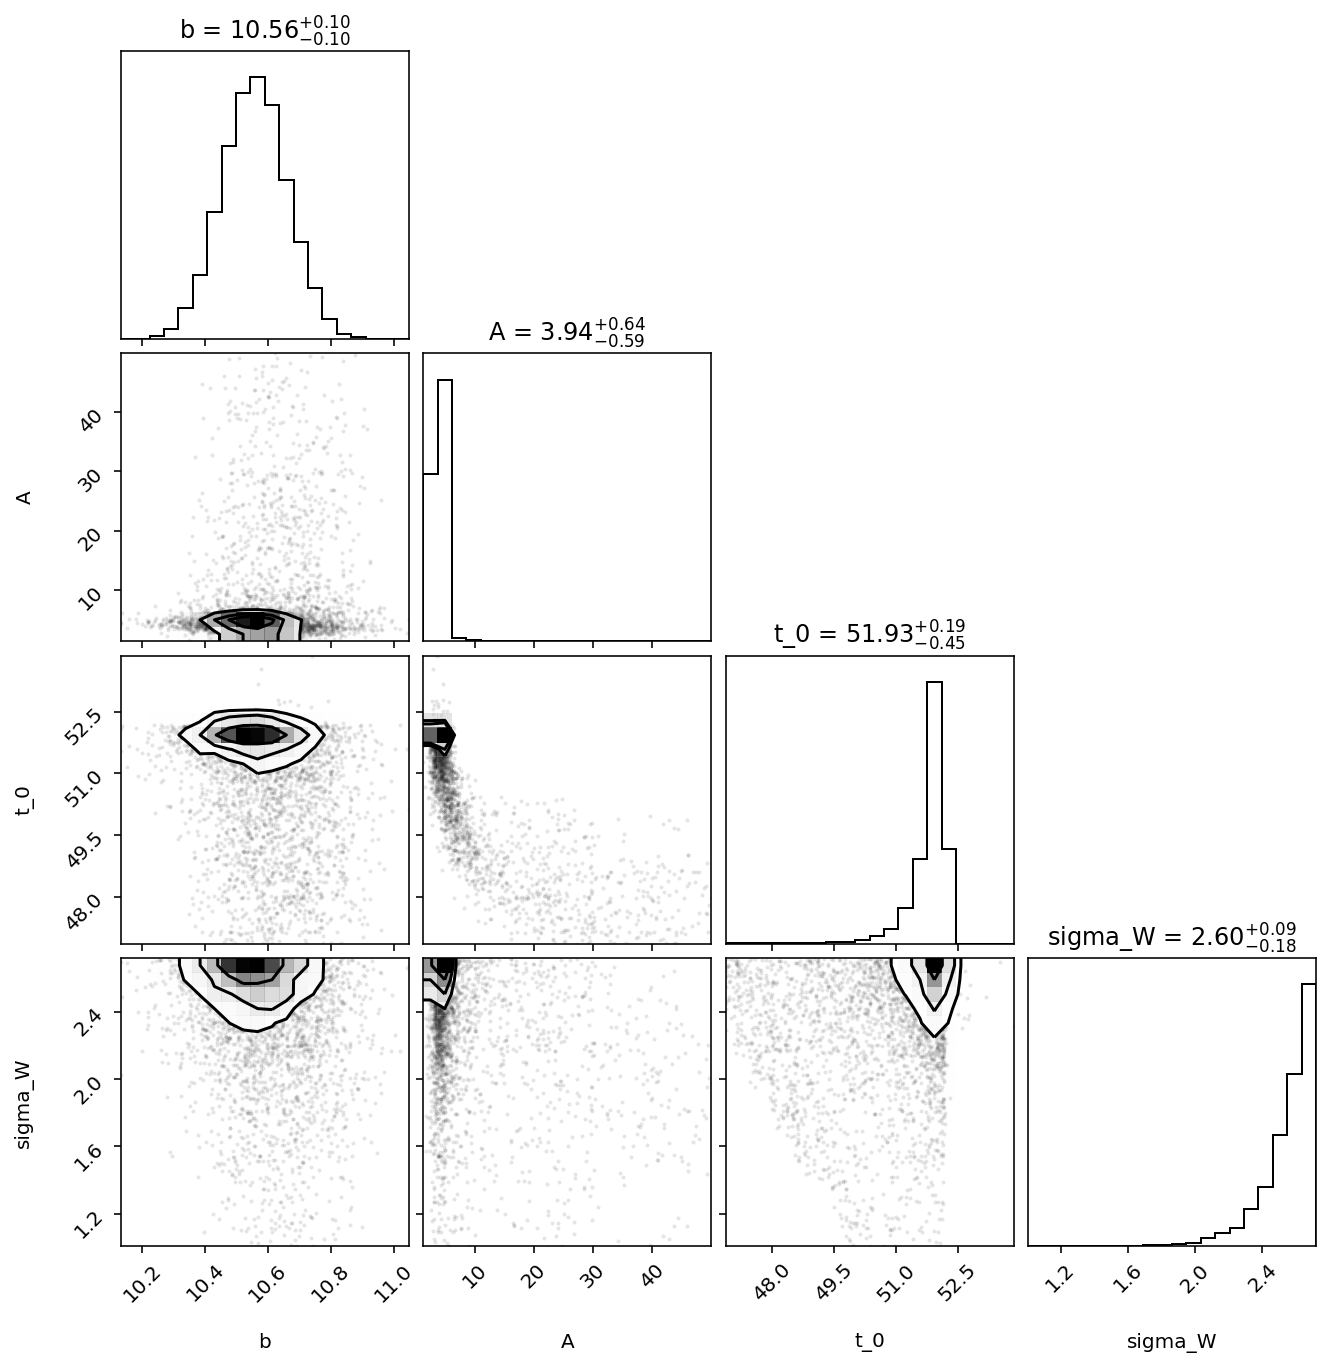

In [22]:
from ultranest.plot import cornerplot
cornerplot(burst)
cornerplot(gauss)


#### Corner plots look very similar! Although, the parameter of A looks off ( ~28  vs ~4 )

In [23]:
## Comparing both models with Bayes Factor M2/M1
bf_m1 = np.exp(burst['logz'])
bf_m2 = np.exp(gauss['logz'])
bayes_factor = bf_m2/bf_m1
print('Bayes Factor is = {:.2f}'.format(bayes_factor))

Bayes Factor is = 340.87


#### Model 2 Gaussian is favored over the burst model 